# Exercises

<font size='4'>
Lets start by improving on the bigram frequency model by implementing a generic n-gram model.
</font>

In [1]:
with open('names.txt') as f:
	words = f.read().splitlines()

In [2]:
import torch

In [31]:
class ngram:
	"""
	n-gram model using counting to train and generate new words.
	"""

	def __init__(self):
		"""
		Initialize the instance by setting _train to False.
		"""
		self._train = False

	def train(self, data, n: int = 1, smoothing: int = 0):
		"""
		Method to train the model given a list of words, the size of the context to be used, and smoothing.
		Arguments:
			data: list of words to be used for training
			n: integer that is size of context to be used to predict next character
			smoothing: integer that is false count added to all elements
		Returns:
			None
		"""
		self.n = n
		self.smoothing = smoothing
		self.ctoi = {c: i+1 for i, c in enumerate(sorted(list(set(''.join(data)))))}
		self.ctoi['.'] = 0
		self.itoc = {i: c for c, i in self.ctoi.items()}
		self.context_indices = lambda x: self.ctoi[x]
		self.N = torch.zeros([len(self.ctoi)] * (n+1), dtype=torch.int32)
		self.N += smoothing

		for word in data:
			context = ['.']*n
			for char in word + '.':
				indices = tuple(map(self.context_indices, context))
				self.N[indices][self.ctoi[char]] += 1
				context = context[1:] + [char]

		self.P = self.N / self.N.sum(dim=n, keepdim=True)
		self._train = True

	def eval(self, data) -> float:
		"""
		Method to evaluate performance of the trained model using the negative log-likelihood function.
		Arguments:
			data: list of strings to evaluate the performance of the model on.
		Returns:
			average negative log-likelihood calculated over whole dataset
		"""
		if self._train is None:
			print("Model must be trained first")
			return

		nll = 0
		n = 0
		for word in data:
			context = ['.']*self.n
			for char in word + '.':
				indices = tuple(map(self.context_indices, context))
				idx = self.ctoi[char]
				p = self.P[indices] # probabilities of all characters to follow context (conditioning on context)
				nll += -torch.log(p[idx])
				n += 1
				context = context[1:] + [char]

		print(f"Loss of {self.n+1}-gram model with smoothing of {self.smoothing}: {nll.item()/n}")
		return nll.item()/n

	def generate(self, n, generator=None):
		""" Generate n new things from the trained model. Can make it deterministic, by setting generator to True
		Otherwise can leave generator as None or provide own generator. """

		if self._train is None:
			print("Model must be trained first")
			return

		if isinstance(generator, bool) and generator:
			generator = torch.Generator().manual_seed(2147483647)
		elif not isinstance(generator, torch.Generator):
			generator = None
		
		for _ in range(n):
			context = ['.']*self.n
			word = ''
			while True:
				indices = tuple(map(self.context_indices, context))
				probs = self.P[indices]
				choice = torch.multinomial(probs, 1, replacement=True, generator=generator).item()
				if choice == 0:
					break
				word += self.itoc[choice]
				context = context[1:] + [self.itoc[choice]]
			print(word)

We can now compare a bunch of n-gram models and their performance.

In [32]:
losses = []

for i in range(1, 6):
	model = ngram()
	model.train(words, i)
	losses.append(model.eval(words))

Loss of 2-gram model with smoothing of 0: 2.454094088872915
Loss of 3-gram model with smoothing of 0: 2.1856520879173864
Loss of 4-gram model with smoothing of 0: 1.8840234159266436
Loss of 5-gram model with smoothing of 0: 1.6055300114838744
Loss of 6-gram model with smoothing of 0: 1.477782867111411


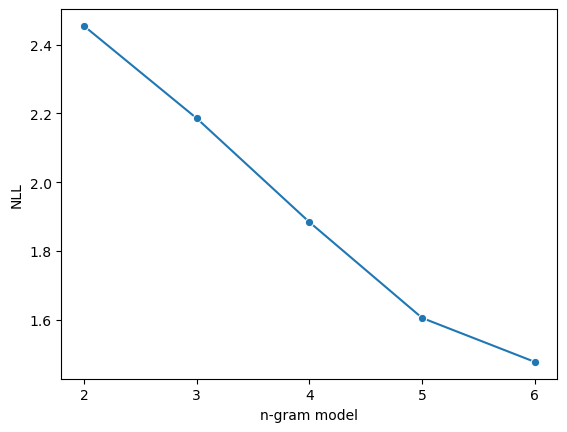

In [33]:
import seaborn as sns

ax = sns.lineplot(x=list(range(2, 7)), y=losses, marker="o")
ax.set(xlabel="n-gram model", ylabel="NLL")
ax.set_xticks(list(range(2,7)))

We see that the larger models perform better as they have more prior information when picking the next letter. Beyond 6-gram models, the space requirements grow too large, so we're going to limit them till there.

<font size='4'>
Lets now do the same, but use a neural network architecture. Firstly we need to construct the dataset and labels.
</font>

In [73]:
from itertools import product

class Dataset:
	def __init__(self, data, n):
		characterSet = set(''.join(data))
		characterSet.add('.')
		self.ctoi = {c: i for i, c in enumerate(sorted(list(characterSet)))}
		self.itoc = {i: c for c, i in self.ctoi.items()}
		self.encoded = {c: i for i, c in enumerate(product(sorted(list(set(characterSet))), repeat=n))}
		self.decoded = lambda x: self.encoded[x]
		self.x, self.y = [], []
		for word in words:
			context = ["."]*n
			for char in word + ".":
				self.x.append(self.decoded(tuple(context)))
				self.y.append(self.ctoi[char])
				context = context[1:] + [char]

In [81]:
dataset = Dataset(words, 2)
len(torch.tensor(dataset.x, dtype=torch.int64))


228146

We now need create a generalized one layer neural net without an activation function.

In [35]:
import torch.nn.functional as F

In [85]:
from typing import List, Union

class ngramNN:
	"""
	Generic neural net based class for next character prediction using a single layer of 27 neurons
	and no activation function.
	"""

	def __init__(self, n, dataset: Dataset):
		"""
		Initialize the generic neural net
		Arguments:
			n: integer that is the size of the context
		"""
		self.n = n
		self.w = None
		self.dataset = dataset

	def train(self, iterations: int, lr: float, reg_strength: Union[bool, float] = 0.01, generator=None):
		"""
		Method to train the neural net given the data and labels, how many iterations to train for, learning rate
		regularization strength.
		Arguments:
			x_train: torch.Tensor containing all training data points for each update
			y_train: torch.Tensor containing all training labels for corresponding data points
			iterations: integer for number of update steps
			lr: float to determine update step size
			reg_strength: float to determine effect of regularization
		"""
		if isinstance(reg_strength, bool):
			if reg_strength:
				reg_strength = 0.01
			else:
				reg_strength = 0.0

		if isinstance(generator, bool) and generator:
			generator = torch.Generator().manual_seed(2147483647)
		elif not isinstance(generator, torch.Generator):
			generator = None

		x_train, y_train = torch.tensor(self.dataset.x, dtype=torch.int64), torch.tensor(self.dataset.y, dtype=torch.int64)
		#xenc = F.one_hot(x_train, len(self.dataset.encoded)).float()

		if not self.w:
			self.w = torch.randn((len(self.dataset.encoded), 27), generator=generator, dtype=torch.float32, requires_grad=True)

		for _ in range(iterations):
			# forward step
			logits = self.w[x_train]
			count = logits.exp()
			probs = count / count.sum(dim=1, keepdim=True)
			loss = -probs[torch.arange(y_train.nelement()), y_train].log().mean() + reg_strength * (self.w.data**2).mean()

			# backward step
			self.w.grad = None
			loss.backward()

			# update step
			self.w.data += -lr*self.w.grad

			#print(f"{loss=}")
			
	def eval(self, x_test = None, y_test = None):
		"""
		Method to evaluate the model on given data
		Arguments:
			x_test: torch.Tensor containing all test data
			y_test: torch.Tensor containing all corresponding labels
		Returns:
			mean negative log-likelihood of model over test data
		"""
		if not x_test:
			x_test, y_test = torch.tensor(self.dataset.x, dtype=torch.int64), torch.tensor(self.dataset.y, dtype=torch.int64)
		#xenc = F.one_hot(x_test, len(self.dataset.encoded)).float()
		logits = self.w[x_test]
		count = logits.exp()
		probs = count / count.sum(dim=1, keepdim=True)
		nll = -probs[torch.arange(y_test.nelement()), y_test].log().mean()

		print(f"Loss of {self.n+1}-gram neural net model: {nll.item()}")
		return nll.item()

	def __call__(self, x: Union[str, List[str], List[int]]):
		if isinstance(x, str):
			x = str.split()

		if isinstance(x, List[str]):
			x = torch.tensor(self.dataset.decoded(tuple(x)), dtype=torch.int64)
		elif isinstance(x, List[int]):
			x = torch.tensor(x, dtype=torch.int64)

		#xenc = F.one_hot(x, len(self.dataset.encoded)).float()
		logits = self.w[x]
		count = logits.exp()
		probs = count/count.sum(dim=1, keepdim=True)
		return probs
		
	def generate(self, n, generator=None):
		""" Generate n new things from the trained model. Can make it deterministic, by setting generator to True
		Otherwise can leave generator as None or provide own generator. """

		if isinstance(generator, bool) and generator:
			generator = torch.Generator().manual_seed(2147483647)
		elif not isinstance(generator, torch.Generator):
			generator = None

		for _ in range(n):
			context = [0]*self.n
			word = ''
			while True:
				x = torch.tensor(context, dtype=torch.int64)
				#xenc = F.one_hot(x, len(self.dataset.encoded)).float()
				logits = self.w[x]
				count = logits.exp()
				probs = count/count.sum(dim=1, keepdim=True)
				choice = torch.multinomial(probs, 1, replacement=True, generator=generator).item()
				if choice == 0:
					break
				word += self.dataset.itoc[choice]
				context = context[1:] + [choice]
			print(word)

Similar to the above experiments we will construct and train n-gram models for $n \in [2,6]$

In [87]:
losses = []

for i in range(1, 6):
	dataset = Dataset(words, i)
	model = ngramNN(i, dataset)
	model.train(iterations=1000, lr=10, reg_strength=0.01, generator=True)
	losses.append(model.eval())

Loss of 2-gram neural net model: 2.4623842239379883
Loss of 3-gram neural net model: 2.3817245960235596
Loss of 4-gram neural net model: 2.6849074363708496
Loss of 5-gram neural net model: 2.995709180831909


KeyboardInterrupt: 

We can plot the final loss of each model and see how a more complex model performs

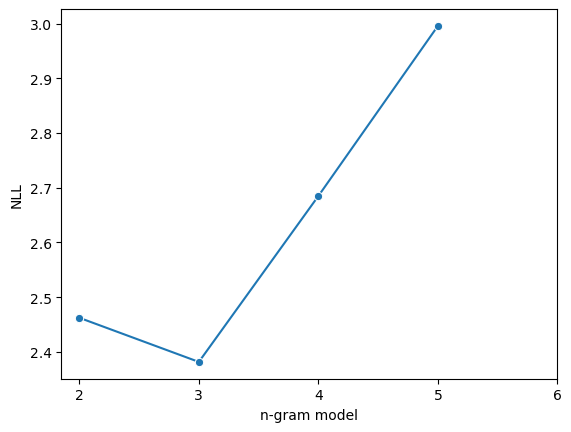

In [89]:
ax = sns.lineplot(x=list(range(2, 6)), y=losses, marker="o")
ax.set(xlabel="n-gram model", ylabel="NLL")
ax.set_xticks(list(range(2,7)))